In [1]:
#!pip install numpy matplotlib seaborn scikit-learn scikit-image torch torchvision torchaudio medpy

### 0. Imports

In [2]:
from torch.utils.data import DataLoader
from torchvision import transforms
from progressBar import printProgressBar

import medicalDataLoader
import argparse
from utils import *

from UNet_Base import *
from UNet_2_0 import *
import random
import torch
import pdb

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from utils_mac import getTargetSegmentation, dice_score

import numpy as np
import torch
import torch.nn.functional as F
from scipy.ndimage import distance_transform_edt as edt
from scipy import ndimage as ndi

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt



In [3]:

import torch.nn as nn
import os
import time
import matplotlib.patches as mpatches


In [4]:
import warnings
warnings.filterwarnings("ignore")

## Architecture du modèle (Basé sur UNet)
En blanc le modèle de base, <span style="color: yellow;">en jaune nos améliorations non terminées,</span> <span style="color: lightgreen;">en vert les améliorations terminées</span>

L’architecture baseline suit la structure classique d’un UNet : *Encoder --> Bottleneck --> Decoder* avec des skip connection skip connections entre blocs symétriques.

### Chemin contractant : Encoder

- On prend en entrée une image à 1 canal et on compresse progressivement les features via 4 blocs encoder :
    - `enc1` : 1 --> 4 canaux
    - `enc2` : 4 --> 8 canaux
    - `enc3` : 8 --> 16 canaux
    - `enc4` : 16 --> 32 canaux (avec dropout pour la régularisation)

- Chaque bloc encoder effectue :
    - une convolution 3×3
    - une normalisation BatchNorm
    - un ReLU
    - <span style="color: yellow;">un dropout optionnel (ajout pour régularisation)</span>
    - un MaxPool pour réduire la résolution spatiale

Ces blocs permettent de capturer progressivement des caractéristiques de plus en plus complexes tout en compressant l’information.

### Bottleneck : Couche centrale

- On arrive au bottleneck (`center`) 32 --> 64 --> 32.

C’est la zone où l’image est représentée de manière la plus compacte avant la reconstruction.

### Bottleneck : Chemin expansif : Decoder

- L’image est ensuite reconstruite via 4 blocs decoder :
    - `dec4` : 64 --> 32 --> 16
    - `dec3` : 32 -6> 16 --> 8
    - `dec2` : 16 --> 8 --> 4
    - `dec1` : 2 convolutions 3*3 (4 --> 4 --> 4) 
 
- Chaque bloc decoder effectue : 
    - une convolution 3×3
    - une normalisation BatchNorm
    - un ReLU
    - un upsampling avec ConvTranspose2d



### Skip Connections

Les sorties des blocs encoder sont concaténées aux blocs decoder correspondants. 
- pour réinjecter des détails locaux provenant de l’encoder, ce qui limite la perte d'information due au bottleneck

### Couche finale

La couche `final` est une convolution 1×1 qui produit C logits pour les C classes --> on obtient un tenseur au format [B, C, H, W]

- B	Taille du batch
- C	Nombre de classes 
- H	Hauteur de l’image
- W	Largeur 

Pour **B** images, pour i allant de 0 à B --> la sortie pour [image i] contient **C** matrices (= une matrice par classe) de dimension **H*W**, avec un logit (=output avant le softmax) pour chaque pixel.

## Définition d'une nouvelle fonction coût
total_loss = (
    0.7 * ce_loss +
    0.2 * dice_loss +
    0.1 * ramp * boundary_loss
)

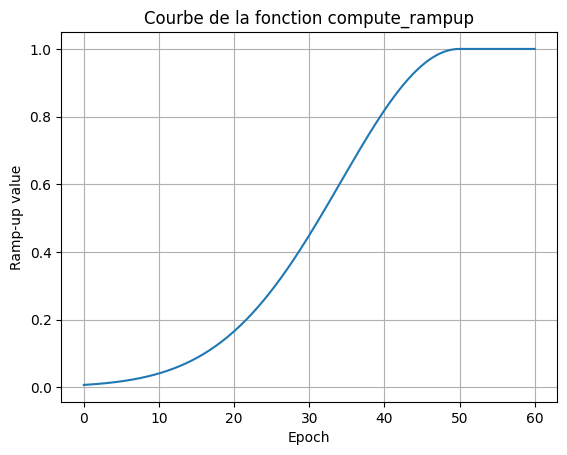

In [5]:
def compute_rampup(epoch, rampup_length=50):
    if epoch < rampup_length:
        phase = 1.0 - epoch / rampup_length
        return float(np.exp(-5.0 * phase * phase))
    else:
        return 1.0

# Génération des points
epochs = np.linspace(0, 60, 300)
values = [compute_rampup(e) for e in epochs]

# Tracé de la courbe
plt.figure()
plt.plot(epochs, values)
plt.xlabel("Epoch")
plt.ylabel("Ramp-up value")
plt.title("Courbe de la fonction compute_rampup")
plt.grid(True)
plt.show()

In [6]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super().__init__()
        self.smooth = smooth
    
    def forward(self, pred, target):
        """
        pred : [B, C, H, W]
        target : [B, H, W] avec labels {0..C-1}
        """
        num_classes = pred.shape[1]

        pred_soft = F.softmax(pred, dim=1)

        # One-hot du target : [B, C, H, W]
        target_onehot = F.one_hot(target, num_classes).permute(0, 3, 1, 2).float()

        intersection = (pred_soft * target_onehot).sum(dim=(0,2,3))
        union = pred_soft.sum(dim=(0,2,3)) + target_onehot.sum(dim=(0,2,3))

        dice = (2 * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1 - dice.mean()

        return dice_loss


In [7]:
def compute_sdf_batch(target_seg, num_classes):
    """
    Compute Signed Distance Map (SDF) for a batch of segmentation maps.

    Parameters
    ----------
    target_seg : torch.Tensor
        Tensor [B, H, W] contenant les classes entières (0..C-1)
    num_classes : int
        Nombre de classes

    Returns
    -------
    torch.Tensor
        SDF tensor [B, C, H, W]
    """
    target_seg = target_seg.cpu().numpy()  # → numpy: [B,H,W]
    B, H, W = target_seg.shape

    sdf_batch = np.zeros((B, num_classes, H, W), dtype=np.float32)

    for b in range(B):
        for c in range(num_classes):

            gt_c = (target_seg[b] == c).astype(np.uint8)

            if gt_c.sum() == 0:
                # Si la classe n'existe pas → SDF = 0 partout
                continue

            # distances à l’extérieur
            negmask = 1 - gt_c
            dist_out = edt(negmask)

            # distances à l’intérieur
            dist_in = edt(gt_c)

            sdf = dist_out - dist_in
            sdf_batch[b, c] = sdf

    return torch.tensor(sdf_batch)


In [8]:
class BoundaryLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, target_sdf):
        """
        pred : [B, C, H, W], logits
        target_sdf : [B, C, H, W], signed distance maps
        """

        pred_probs = F.softmax(pred, dim=1)

        loss = (pred_probs * target_sdf).abs().mean()
        return loss


In [9]:
def compute_rampup(epoch, rampup_length=50):
    if epoch < rampup_length:
        phase = 1.0 - epoch / rampup_length
        return float(np.exp(-5.0 * phase * phase))
    else:
        return 1.0

In [98]:
class CombinedLoss(nn.Module):
    def __init__(self, num_classes, weight):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=weight)
        self.dice = SoftDiceLoss(num_classes)
        self.boundary = BoundaryLoss()

    def forward(self, pred, target, target_sdf, epoch):
        
        ce_loss = self.ce(pred, target)
        dice_loss = self.dice(pred, target)
        boundary_loss = self.boundary(pred, target_sdf)

        # ramp-up du boundary loss
        ramp = compute_rampup(epoch, rampup_length=50)

        # pondération totale
        total_loss = (
            0.6 * ce_loss +
            0.3 * dice_loss +
            0.1 * ramp * boundary_loss
        )

        return total_loss, ce_loss, dice_loss, boundary_loss, ramp

## 1. Définition des métriques

### 1.1 Dice

In [11]:
def dice_score(pred, target, num_classes, eps=1e-7):
    """
    Calcule le Dice score pour chaque classe

    Parameters
    ----------
    pred : voir le markdown plus haut
    target : format [B, H, W]
        contient une seule valeur (et une seule matrice) par pixel :
        (0=classe 0, 1=classe 1, 2=classe 2, 3=classe 3)
    num_classes : int
        nombre de classes - incluant le background
    eps : float
        petite valeur pour éviter la division par zéro

    Returns
    -------
    dice_per_class : tensor
        tensor contenant le dice score pour chaque classe (dim [num_classes])
    """
    pred_classes = torch.argmax(pred, dim=1)  # retourne une pred par pixel au format [B, H, W]

    dice_per_class = []
    # on itere sur toutes les classes pour
    for c in range(num_classes):
        # création de masques binaires pour la classe c pour pred et target
        pred_c = (pred_classes == c).float()
        target_c = (target == c).float() 

        intersection = (pred_c * target_c).sum() # ne donne 1 que si la prédition et  la target correspondent
        union = pred_c.sum() + target_c.sum() # la somme des pixels prédits + la somme des pixels réels

        dice = (2 * intersection + eps) / (union + eps)
        dice_per_class.append(dice)

    # retoune un tensor de dimension [num_classes]
    return torch.stack(dice_per_class)

### 2.1 Average Surface Distance (ASD)

In [12]:
def get_boundary(mask):
    """
    Extrait les pixels de frontière du masque (binaire).
    """
    mask = mask.astype(np.uint8)
    # Convolution Laplacienne pour obtenir les bords
    lap = ndi.laplace(mask)
    boundary = np.logical_and(mask == 1, lap != 0)
    return boundary


In [13]:
def asd_per_class(pred, gt):
    """
    Calcule l'Average Surface Distance (ASD) entre deux masques binaires.

    pred : ndarray (H, W) 
        Masque prédiction (0 ou 1)
    gt : ndarray (H, W) 
        Masque ground-truth (0 ou 1)

    Returns
    -------
    float
        ASD (Average Surface Distance)
    """

    pred = pred.astype(np.uint8)
    gt = gt.astype(np.uint8)

    # Extraire frontières
    pred_b = get_boundary(pred)
    gt_b = get_boundary(gt)

    # Gestion du cas vide
    if pred_b.sum() == 0 or gt_b.sum() == 0:
        return np.nan

    # Distance transform sur GT
    dt_gt = ndi.distance_transform_edt(~gt_b)
    d_pred_to_gt = dt_gt[pred_b]

    # Distance transform sur PRED
    dt_pred = ndi.distance_transform_edt(~pred_b)
    d_gt_to_pred = dt_pred[gt_b]

    # ASD = moyenne bidirectionnelle
    return (d_pred_to_gt.mean() + d_gt_to_pred.mean()) / 2.0


In [14]:
def hausdorff_distance_per_class(pred, gt):
    """
    Calcule la distance de Hausdorff entre deux masques binaires.

    pred : ndarray (H, W)
    gt : ndarray (H, W)

    Returns
    -------
    float
        Distance de Hausdorff (pixels)
    """

    pred = pred.astype(np.uint8)
    gt = gt.astype(np.uint8)

    pred_b = get_boundary(pred)
    gt_b = get_boundary(gt)

    if pred_b.sum() == 0 or gt_b.sum() == 0:
        return np.nan

    dt_gt = ndi.distance_transform_edt(~gt_b)
    dt_pred = ndi.distance_transform_edt(~pred_b)

    dist_pred_to_gt = dt_gt[pred_b]
    dist_gt_to_pred = dt_pred[gt_b]

    # Hausdorff = max des distances bidirectionnelles
    hd = max(dist_pred_to_gt.max(), dist_gt_to_pred.max())
    return hd


In [15]:
def metrics_multiclass(pred, gt, num_classes):
    """
    Calcule DICE, ASD et HD par classe.

    pred : ndarray [H, W] valeurs {0..num_classes-1}
    gt   : ndarray [H, W]

    Returns
    -------
    dict
        {
            "dice": [c1, c2, ...],
            "asd":  [c1, c2, ...],
            "hd":   [c1, c2, ...]
        }
    """

    dice_scores = []
    asd_scores = []
    hd_scores = []

    for c in range(num_classes):
        pred_c = (pred == c).astype(np.uint8)
        gt_c   = (gt == c).astype(np.uint8)

        # DICE déjà existant dans ton code :
        intersection = (pred_c & gt_c).sum()
        denom = pred_c.sum() + gt_c.sum()
        dice = (2 * intersection / denom) if denom > 0 else np.nan

        asd = asd_per_class(pred_c, gt_c)
        hd  = hausdorff_distance_per_class(pred_c, gt_c)

        dice_scores.append(dice)
        asd_scores.append(asd)
        hd_scores.append(hd)

    return {
        "dice": np.array(dice_scores),
        "asd":  np.array(asd_scores),
        "hd":   np.array(hd_scores)
    }


In [16]:
def metrics_multiclass(pred, gt, num_classes):
    """
    Calcule DICE, ASD et HD par classe.

    pred : ndarray [H, W] valeurs {0..num_classes-1}
    gt   : ndarray [H, W]

    Returns
    -------
    dict
        {
            "dice": [c1, c2, ...],
            "asd":  [c1, c2, ...],
            "hd":   [c1, c2, ...]
        }
    """

    dice_scores = []
    asd_scores = []
    hd_scores = []

    for c in range(num_classes):
        pred_c = (pred == c).astype(np.uint8)
        gt_c   = (gt == c).astype(np.uint8)

        # DICE déjà existant dans ton code :
        intersection = (pred_c & gt_c).sum()
        denom = pred_c.sum() + gt_c.sum()
        dice = (2 * intersection / denom) if denom > 0 else np.nan

        asd = asd_per_class(pred_c, gt_c)
        hd  = hausdorff_distance_per_class(pred_c, gt_c)

        dice_scores.append(dice)
        asd_scores.append(asd)
        hd_scores.append(hd)

    return {
        "dice": np.array(dice_scores),
        "asd":  np.array(asd_scores),
        "hd":   np.array(hd_scores)
    }


## 2. Fonction de validation

In [ ]:
def validate(model, loader, criterion, num_classes, visualise=True, n_examples=1, show_confusion=False):
    """
    Evalue les performances du modèle sur un ensemble de validation (dice + loss)

    Parameters
    ----------
    model : torch.nn.Module
        Le modèle à évaluer
    loader : torch.utils.data.DataLoader
        Dataloader avec les images + labels pour la validation
    criterion : callable
        Fonction de perte utilisée pour calculer le loss 
    num_classes : int
        Nombre de classes de segmentation pour le dice

    Returns
    -------
    avg_loss : float
        Loss moyen sur l’ensemble du dataset
    dice_mean : numpy.ndarray
        Tableau de dim [num_classes] contenant la moyenne du dice 
    pour chaque classe de segmentation

    """
    model.eval()
    total_loss = 0.0
    dice_total = []
    
    # Pour la matrice de confusion
    all_preds = []
    all_gts = []

    import matplotlib.patches as mpatches
    cmap = "jet"
    class_colors = plt.cm.get_cmap(cmap, num_classes)
    
    class_names = ["Fond", "Cellule", "Noyau", "Membrane"]  # taille = num_classes

    legend_patches = [
        mpatches.Patch(color=class_colors(i), label=class_names[i])
        for i in range(num_classes)
    ]

    example_count = 0

    with torch.no_grad():

        for images, labels, _ in loader:

            images = to_var(images)
            labels = to_var(labels)

            outputs = model(images)
            segmentation_classes = getTargetSegmentation(labels)

            # Loss
            loss = criterion(outputs, segmentation_classes)
            total_loss += loss.item()

            # Dice
            dice = dice_score(outputs, segmentation_classes, num_classes)
            dice_total.append(dice.cpu().numpy())

            # ====== MATRICE DE CONFUSION (ACCUMULATION) ====== #
            preds = torch.argmax(outputs, dim=1)     # [B, H, W]
            all_preds.append(preds.cpu().numpy().reshape(-1))
            all_gts.append(segmentation_classes.cpu().numpy().reshape(-1))
            # ================================================== #

            # ====== VISUALISATION (multi exemples) ====== #
            if visualise and example_count < n_examples:
                batch_size = images.size(0)
                to_show = min(batch_size, n_examples - example_count)

                for idx in range(to_show):
                    example_count += 1

                    img_np = images[idx][0].cpu().numpy()
                    gt_np = segmentation_classes[idx].cpu().numpy()
                    pred_np = preds[idx].cpu().numpy()

                    m = metrics_multiclass(pred_np, gt_np, num_classes)

                    print("Dice:", m["dice"])
                    print("ASD :", m["asd"])
                    print("HD  :", m["hd"])


                    plt.figure(figsize=(16,4))

                    plt.subplot(1,4,1)
                    plt.imshow(img_np, cmap="gray")
                    plt.title("Image")
                    plt.axis("off")

                    plt.subplot(1,4,2)
                    plt.imshow(gt_np, cmap=cmap, vmin=0, vmax=num_classes-1)
                    plt.title("Mask GT")
                    plt.axis("off")

                    plt.subplot(1,4,3)
                    plt.imshow(pred_np, cmap=cmap, vmin=0, vmax=num_classes-1)
                    plt.title("Prédiction")
                    plt.axis("off")

                    plt.subplot(1,4,4)
                    plt.imshow(img_np, cmap="gray")
                    plt.imshow(pred_np, cmap=cmap, alpha=0.45, vmin=0, vmax=num_classes-1)
                    plt.title("Overlay")
                    plt.axis("off")

                    plt.figlegend(handles=legend_patches,
                                  loc="lower center",
                                  ncol=num_classes,
                                  bbox_to_anchor=(0.5, -0.15))
                    plt.tight_layout()
                    plt.show()

            # =============================================== #


    # ==========================
    #   MATRICE DE CONFUSION
    # ==========================
    if show_confusion:

        preds_flat = np.concatenate(all_preds)      # shape [N_pixels]
        gts_flat   = np.concatenate(all_gts)

        cm = confusion_matrix(gts_flat, preds_flat, labels=np.arange(num_classes))

        plt.figure(figsize=(7,6))
        sns.heatmap(cm,
                    annot=True,
                    fmt="d",
                    cmap="Blues",
                    xticklabels=[f"Pred {i}" for i in range(num_classes)],
                    yticklabels=[f"True {i}" for i in range(num_classes)])
        plt.title("Matrice de confusion (pixel-wise)")
        plt.xlabel("Classe prédite")
        plt.ylabel("Classe réelle")
        plt.tight_layout()
        plt.show()

    # ==========================

    dice_mean = np.mean(np.array(dice_total), axis=0)
    return total_loss / len(loader), dice_mean, m

In [131]:
def compute_sdf(mask):
    """Calcule la fonction de distance signée (SDF) pour un masque binaire."""
    mask = mask.astype(np.bool_)

    if mask.sum() == 0:
        return np.zeros_like(mask, dtype=np.float32)

    dist_in  = edt(mask)
    dist_out = edt(~mask)
    
    sdf = dist_in - dist_out
    return sdf

def validate_simple(
    model,
    loader,
    ce_loss_fn,
    num_classes,
    device,
    n_images=1,
    show_graphics=True, # Ce paramètre contrôle maintenant si l'on affiche les graphiques ou non
    show_sdf_graphics=False,
    save_dir=None
):
    model.eval()
    total_loss = 0.0
    dice_accum = []
    metrics_accum = []


    cmap = "jet"
    class_colors = plt.cm.get_cmap(cmap, num_classes)

    class_names = ["Backgrond", "Endocarde du ventricule gauche (RV)", "Mycarde du ventricule gauche (Myo)","Endocarde du ventricule gauche (LV)"]  # taille = num_classes

    legend_patches = [
        mpatches.Patch(color=class_colors(i), label=class_names[i])
        for i in range(num_classes)
    ]

    example_count = 0

    with torch.no_grad():
        for images, labels, _ in loader:

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)                         # logits [B,C,H,W]
            # Assurez-vous que getTargetSegmentation est importé
            segmentation_classes = getTargetSegmentation(labels)             # GT classes [B,H,W]

            loss_ce = ce_loss_fn(outputs, segmentation_classes) # Utilisation de la CE pondérée pour la validation
            total_loss += loss_ce.item()

            dice_epoch = dice_score(outputs, segmentation_classes, num_classes) # Assurez-vous que dice_score est importé
            dice_accum.append(dice_epoch)

            preds = torch.argmax(outputs, dim=1)            # [B,H,W]

            preds_np = preds.cpu().numpy()
            gts_np   = segmentation_classes.cpu().numpy()
            imgs_np  = images[:,0].cpu().numpy()

            # ---------- Accumulation metrics ----------
            # Assurez-vous que metrics_multiclass est importé
            for b in range(preds_np.shape[0]):
                m = metrics_multiclass(preds_np[b], gts_np[b], num_classes) 
                metrics_accum.append(m)

            # ---------- Visualisation (Contrôlée par 'show') ----------
            if show_graphics and example_count < n_images:
                batch_size = preds_np.shape[0]
                to_show = min(batch_size, n_images - example_count)

                for i in range(to_show):
                    img  = imgs_np[i]
                    gt   = gts_np[i]
                    pred = preds_np[i]

                    # 1. Afficher l'image, la GT et la prédiction multi-classes (pour contexte)
                    fig_main, axs_main = plt.subplots(1, 4, figsize=(16, 4))


                    factor = 1.5  # >1 = contraste plus fort, <1 = contraste plus faible
                    mean = img.mean()
                    img_contrast = np.clip((img - mean) * factor + mean, 0, 1)

                    brightness = 0.5  # ajouter une valeur positive pour éclaircir
                    img_final = np.clip(img_contrast + brightness, 0, 1)


                    axs_main[0].imshow(img_final, cmap="gray")
                    axs_main[0].set_title("Image")
                    axs_main[0].axis("off")

                    axs_main[1].imshow(gt, cmap=cmap, vmin=0, vmax=num_classes-1)
                    axs_main[1].set_title("Mask GT")
                    axs_main[1].axis("off")

                    axs_main[2].imshow(pred, cmap=cmap, vmin=0, vmax=num_classes-1)
                    axs_main[2].set_title("Prédiction")
                    axs_main[2].axis("off")


                    axs_main[3].imshow(img_final, cmap="gray")
                    axs_main[3].imshow(pred, cmap=cmap, alpha=0.45, vmin=0, vmax=num_classes-1)
                    axs_main[3].set_title("Overlay")
                    axs_main[3].axis("off")

                    # Ajuster l'espace pour que la légende ne chevauche pas les sous-graphes
                    fig_main.tight_layout(rect=[0, 0.1, 1, 1])  # laisse un espace en bas pour la légende

                    # Ajouter la légende de figure
                    fig_main.legend(handles=legend_patches,
                                    loc="lower center",
                                    ncol=num_classes,
                                    bbox_to_anchor=(0.5, 0.05))  # position ajustée sous les sous-graphes

                    plt.tight_layout()
                    plt.show()


                    if save_dir is not None:
                         os.makedirs(save_dir, exist_ok=True)
                         plt.savefig(
                             f"{save_dir}/epoch_image_{example_count}_multiclass.png",
                             dpi=150
                         )
                    
                    if show_graphics: plt.show()
                    plt.close(fig_main)
                    if show_sdf_graphics:
                        # 2. Visualisation des SDF pour chaque classe de premier plan (1, 2, ..., num_classes-1)
                        # Nous supposons que la classe 0 est le background
                        for c in range(1, num_classes):
                            # Création des masques binaires pour la classe c
                            mask_gt_c = (gt == c)
                            mask_pred_c = (pred == c)

                            # Calcul des SDF
                            sdf_gt_c = compute_sdf(mask_gt_c)
                            sdf_pred_c = compute_sdf(mask_pred_c)

                            # Calul de l'Erreur SDF (|SDF_GT - SDF_Pred|)
                            sdf_error_c = np.abs(sdf_gt_c - sdf_pred_c)

                            # Crée une figure avec les 4 graphiques SDF
                            fig_sdf, axs_sdf = plt.subplots(1, 4, figsize=(20, 5))

                            # Graphiques
                            axs_sdf[0].imshow(img, cmap="gray")
                            axs_sdf[0].contour(mask_gt_c, colors='red', linewidths=1.5)
                            axs_sdf[0].set_title(f"Image et Bordure GT (Cl. {c})")
                            axs_sdf[0].axis("off")

                            axs_sdf[1].imshow(sdf_gt_c, cmap="seismic")
                            axs_sdf[1].set_title(f"SDF GT (Cl. {c})")
                            axs_sdf[1].axis("off")

                            axs_sdf[2].imshow(sdf_pred_c, cmap="seismic")
                            axs_sdf[2].set_title(f"SDF Pred (Cl. {c})")
                            axs_sdf[2].axis("off")

                            axs_sdf[3].imshow(sdf_error_c, cmap="viridis")
                            axs_sdf[3].set_title(f"Erreur SDF |GT-Pred| (Cl. {c})")
                            axs_sdf[3].axis("off")

                            plt.tight_layout()

                            # if save_dir is not None:
                            #     os.makedirs(save_dir, exist_ok=True)
                            #     plt.savefig(
                            #         f"{save_dir}/epoch_image_{example_count}_sdf_class_{c}.png",
                            #         dpi=150
                            #     )
                            
                            if show_sdf_graphics: plt.show()
                            plt.close(fig_sdf)

                    example_count += 1
            
            # Condition pour sortir de la boucle des lots après n_images, si show=True
            if show_graphics and example_count >= n_images:
                 break


    # ---------- Dice moyen et Aggregation des métriques ----------
    if len(dice_accum) > 0:
        dice_mean = np.mean(np.stack(dice_accum, axis=0), axis=0)
    else:
        dice_mean = np.zeros((num_classes,))

    if len(metrics_accum) > 0:
        all_dice = np.stack([m["dice"] for m in metrics_accum], axis=0)
        all_asd  = np.stack([m["asd"]  for m in metrics_accum], axis=0)
        all_hd   = np.stack([m["hd"]   for m in metrics_accum], axis=0)

        agg = {
            "dice": np.nanmean(all_dice, axis=0),
            "asd" : np.nanmean(all_asd , axis=0),
            "hd"  : np.nanmean(all_hd  , axis=0),
        }
    else:
        agg = {
            "dice": np.zeros(num_classes),
            "asd" : np.zeros(num_classes),
            "hd"  : np.zeros(num_classes)
        }

    return total_loss / max(1, len(loader)), dice_mean, agg

## 3. runTraining

In [19]:
def runTraining(model_class=UNet):

    print('-' * 40)
    print('~~~~~~~~  Starting the training... ~~~~~~')
    print('-' * 40)

    ## DEFINE HYPERPARAMETERS (batch_size > 1)
    batch_size = 4
    batch_size_val = 4 
    lr = 0.001    # Learning Rate
    epoch = 10 # Number of epochs
    
    root_dir = './Data/'

    print(' Dataset: {} '.format(root_dir))

    ## DEFINE THE TRANSFORMATIONS TO DO AND THE VARIABLES FOR TRAINING AND VALIDATION
    
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    mask_transform = transforms.Compose([
        transforms.ToTensor()
    ])

    train_set_full = medicalDataLoader.MedicalImageDataset('train',
                                                      root_dir,
                                                      transform=transform,
                                                      mask_transform=mask_transform,
                                                      augment=True, # était à False 
                                                      equalize=False)

    train_loader_full = DataLoader(train_set_full,
                              batch_size=batch_size,
                              worker_init_fn=np.random.seed(0),
                              num_workers=0,
                              shuffle=True)


    val_set = medicalDataLoader.MedicalImageDataset('val',
                                                    root_dir,
                                                    transform=transform,
                                                    mask_transform=mask_transform,
                                                    equalize=False)

    val_loader = DataLoader(val_set,
                            batch_size=batch_size_val,
                            worker_init_fn=np.random.seed(0),
                            num_workers=0,
                            shuffle=False)
    
    unlabeled_set = medicalDataLoader.MedicalImageDataset("unlabeled", 
                                                          root_dir, 
                                                          transform=transform)
    
    unlabeled_loader = DataLoader(unlabeled_set, 
                                  batch_size=batch_size,
                                  shuffle=True)


    ## INITIALIZE YOUR MODEL
    num_classes = 4 # NUMBER OF CLASSES

    print("~~~~~~~~~~~ Creating the UNet model ~~~~~~~~~~")
    modelName = model_class.__name__
    print("Model Name: {}".format(modelName))

    ## CREATION OF YOUR MODEL
    net = model_class(num_classes)

    print("Total params: {0:,}".format(sum(p.numel() for p in net.parameters() if p.requires_grad)))

    # DEFINE YOUR OUTPUT COMPONENTS (e.g., SOFTMAX, LOSS FUNCTION, ETC)
    class_weights = torch.tensor([0.1, 5, 5, 5], dtype=torch.float)
    softMax = torch.nn.Softmax(dim=1)
    CE_loss = torch.nn.CrossEntropyLoss(weight=class_weights)

    ## PUT EVERYTHING IN GPU RESOURCES    
    if torch.cuda.is_available():
        net.cuda()
        softMax.cuda()
        CE_loss.cuda()

    ## DEFINE YOUR OPTIMIZER
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    ### To save statistics ####
    lossTotalTraining = []
    Best_loss_val = 1000
    BestEpoch = 0

    val_loss_list = []
    dice_list = []
    asd_list = []
    hd_list = []
    
    directory = 'Results/Statistics/' + modelName

    print("~~~~~~~~~~~ Starting the training ~~~~~~~~~~")
    if os.path.exists(directory)==False:
        os.makedirs(directory)

    ## START THE TRAINING
    
    ## FOR EACH EPOCH
    for i in range(epoch):
        epoch_start_time = time.time()
        net.train() # modèle en mode entrainement
        lossEpoch = []
        DSCEpoch = []
        DSCEpoch_w = []
        num_batches = len(train_loader_full)
        
        ## FOR EACH BATCH
        for j, data in enumerate(train_loader_full):
            ### Set to zero all the gradients
            net.zero_grad()
            optimizer.zero_grad()

            ## GET IMAGES, LABELS and IMG NAMES
            images, labels, img_names = data

            ### From numpy to torch variables
            labels = to_var(labels)
            images = to_var(images)

            ################### Train ###################
            #-- The CNN makes its predictions (forward pass)
            net_predictions = net(images)

            #-- Compute the losses --#
            # THIS FUNCTION IS TO CONVERT LABELS TO A FORMAT TO BE USED IN THIS CODE
            segmentation_classes = getTargetSegmentation(labels)
            
            # COMPUTE THE LOSS
            CE_loss_value = CE_loss(net_predictions, segmentation_classes) # XXXXXX and YYYYYYY are your inputs for the CE
            lossTotal = CE_loss_value

            # DO THE STEPS FOR BACKPROP (two things to be done in pytorch)

            lossTotal.backward()  # Calcule les gradients des poids (rétropropagation)
            optimizer.step()      # Met à jour les poids en utilisant l'optimiseur (Adam)
            
            # THIS IS JUST TO VISUALIZE THE TRAINING 
            lossEpoch.append(lossTotal.cpu().data.numpy())
            printProgressBar(j + 1, num_batches,
                             prefix="[Training] Epoch: {} ".format(i),
                             length=15,
                             suffix=" Loss: {:.4f}, ".format(lossTotal))

        # --- CHRONO EPOCH END ---
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        print(f"Epoch {i} terminée en {epoch_duration:.1f}s")
        lossEpoch = np.asarray(lossEpoch)
        lossEpoch = lossEpoch.mean()

        lossTotalTraining.append(lossEpoch)

        # ---- DICE SCORE ---- #
        with torch.no_grad():
            dice = dice_score(net_predictions, segmentation_classes, num_classes)
            DSCEpoch.append(dice.cpu().numpy())


        printProgressBar(num_batches, num_batches,
                             done="[Training] Epoch: {}, LossG: {:.4f}".format(i,lossEpoch))
        
        # VALIDATION PHASE 
        val_loss, val_dice, m = validate(net, val_loader, CE_loss, num_classes)
        print(f"[Validation] Epoch: {i}, Loss: {val_loss:.4f}, Dice: {val_dice}")

        # pour les courbes looss et dice
        val_loss_list.append(val_loss)
        dice_list.append(val_dice)
        asd_list.append(m["asd"])
        hd_list.append(m["hd"])

        # SAUVEGARDE DU MEILLEUR MODELE SELON LE LOSS DE VALIDATION
        if val_loss < Best_loss_val:
            Best_loss_val = val_loss
            BestEpoch = i

            if not os.path.exists('./models/' + modelName):
                os.makedirs('./models/' + modelName)

            torch.save(net.state_dict(), './models/' + modelName + '/' + str(i) + '_Epoch')
            print(f"Best model updated at epoch {i} (val_loss={val_loss:.4f})")

    print("\n----------------------------------------")
    print(f"Best model found at epoch {BestEpoch} with validation loss = {Best_loss_val:.4f}")
    print("----------------------------------------\n")

    return lossTotalTraining, val_loss_list, dice_list, asd_list, hd_list # pour tracer les courbes


        # ## THIS IS HOW YOU WILL SAVE THE TRAINED MODELS AFTER EACH EPOCH. 
        # ## WARNING!!!!! YOU DON'T WANT TO SAVE IT AT EACH EPOCH, BUT ONLY WHEN THE MODEL WORKS BEST ON THE VALIDATION SET!!
        # if not os.path.exists('./models/' + modelName):
        #         os.makedirs('./models/' + modelName)

        #     torch.save(net.state_dict(), './models/' + modelName + '/' + str(i) + '_Epoch')
            
        # np.save(os.path.join(directory, 'Losses.npy'), lossTotalTraining)


In [132]:
def runTraining_combined_loss(model_class=UNet):
    import time
    from scipy.ndimage import distance_transform_edt as edt

    # --- helper: compute_sdf for a single binary mask (numpy) ---
    def compute_sdf(mask):
        # mask : 2D numpy array {0,1}
        if mask.sum() == 0:
            return np.zeros_like(mask, dtype=np.float32)
        negmask = 1 - mask
        dist_out = edt(negmask)   # distance to foreground from outside
        dist_in  = edt(mask)      # distance to background from inside
        sdf = dist_out - dist_in
        return sdf.astype(np.float32)

    # --- helper: compute SDF batch [B, C, H, W] from segmentation_classes [B, H, W] ---
    def compute_sdf_batch(segmentation_classes, num_classes, device):
        """
        segmentation_classes: torch.Tensor [B, H, W] (cpu or device)
        returns torch.Tensor [B, C, H, W] (float32) on device
        """
        seg_np = segmentation_classes.cpu().numpy()
        B, H, W = seg_np.shape
        sdf_batch = np.zeros((B, num_classes, H, W), dtype=np.float32)
        for b in range(B):
            for c in range(num_classes):
                bin_mask = (seg_np[b] == c).astype(np.uint8)
                if bin_mask.sum() == 0:
                    sdf_batch[b, c] = np.zeros((H, W), dtype=np.float32)
                else:
                    sdf_batch[b, c] = compute_sdf(bin_mask)
        return torch.from_numpy(sdf_batch).float().to(device)

    # --- helper: dice per class (returns np.array num_classes) ---
    def dice_per_class_logits(pred_logits, target, num_classes, eps=1e-6):
        # pred_logits: tensor [B,C,H,W], target: [B,H,W]
        pred = torch.argmax(pred_logits, dim=1)  # [B,H,W]
        B = pred.shape[0]
        out = []
        for c in range(num_classes):
            dices = []
            for b in range(B):
                pred_c = (pred[b] == c).float()
                tgt_c = (target[b] == c).float()
                inter = (pred_c * tgt_c).sum()
                denom = pred_c.sum() + tgt_c.sum()
                dice = ((2.0 * inter + eps) / (denom + eps)).item() if denom.item() > 0 else 0.0
                dices.append(dice)
            out.append(np.mean(dices))
        return np.array(out)  # shape (num_classes,)

    # ---------------------------
    # Hyperparams & dataloaders
    # ---------------------------
    batch_size = 4
    batch_size_val = 4
    lr = 0.001
    n_epochs = 10
    root_dir = './Data/'

    transform = transforms.Compose([transforms.ToTensor()])
    mask_transform = transforms.Compose([transforms.ToTensor()])

    train_set_full = medicalDataLoader.MedicalImageDataset('train', root_dir,
                                                          transform=transform,
                                                          mask_transform=mask_transform,
                                                          augment=True, equalize=False)
    train_loader_full = DataLoader(train_set_full, batch_size=batch_size,
                                   worker_init_fn=np.random.seed(0),
                                   num_workers=0, shuffle=True)

    val_set = medicalDataLoader.MedicalImageDataset('val', root_dir,
                                                   transform=transform,
                                                   mask_transform=mask_transform,
                                                   equalize=False)
    val_loader = DataLoader(val_set, batch_size=batch_size_val,
                            worker_init_fn=np.random.seed(0),
                            num_workers=0, shuffle=False)

    unlabeled_set = medicalDataLoader.MedicalImageDataset("unlabeled", root_dir, transform=transform)
    unlabeled_loader = DataLoader(unlabeled_set, batch_size=batch_size, shuffle=True)

    num_classes = 4

    # ---------------------------
    # Model, device, losses, optim
    # ---------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = model_class(num_classes).to(device)

    # class_weights probably in CPU; send to device when creating CE
    class_weights = torch.tensor([0.1, 5, 5, 5], dtype=torch.float).to(device)
    CE_loss = torch.nn.CrossEntropyLoss(weight=class_weights)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    # instantiate CombinedLoss once (expects signature forward(pred, target, sdf, epoch))
    criterion = CombinedLoss(num_classes=num_classes, weight=class_weights)

    # stats containers
    lossTotalTraining = []
    val_loss_list = []
    dice_list = []
    asd_list = []
    hd_list = []
    Best_loss_val = float('inf')
    BestEpoch = 0

    modelName = model_class.__name__
    directory = 'Results/Statistics/' + modelName
    if not os.path.exists(directory):
        os.makedirs(directory)

    # ---------------------------
    # Training loop
    # ---------------------------
    for epoch in range(n_epochs):
        epoch_start_time = time.time()
        net.train()
        batch_losses = []
        batch_dices = []  # store per-batch dice arrays to average for training estimates

        num_batches = len(train_loader_full)
        for j, data in enumerate(train_loader_full):
            images, labels, img_names = data
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # forward
            outputs = net(images)  # logits [B,C,H,W]
            segmentation_classes = getTargetSegmentation(labels).to(device)  # [B,H,W]

            # compute SDF batch (one call)
            target_sdf = compute_sdf_batch(segmentation_classes, num_classes, device)

            # combined loss (expecting epoch argument)
            # signature assumed: criterion(pred, target, target_sdf, epoch)
            # adjust if your CombinedLoss has different signature
            lossTotal, ce_loss_val, dice_loss_val, boundary_loss_val, *rest = criterion(
                outputs, segmentation_classes, target_sdf, epoch
            )
            # if criterion returns ramp or other extras in rest, ignore or use as needed
            lossTotal.backward()
            optimizer.step()

            # logging & accum
            batch_losses.append(float(lossTotal.detach().cpu().item()))

            # compute per-batch dice (averaged over batch)
            batch_dice = dice_per_class_logits(outputs.detach(), segmentation_classes.detach(), num_classes)
            batch_dices.append(batch_dice)

            # progress bar suffix
            ramp = compute_rampup(epoch)

            total_loss = (
                0.7 * ce_loss_val +
                0.2 * dice_loss_val +
                0.1 * ramp * boundary_loss_val
            )

            total_loss_val = total_loss.item()
            
            suffix = (
                f" CE={ce_loss_val:.4f} "
                f"DiceL={dice_loss_val:.4f} "
                f"Bound={boundary_loss_val:.4f} "
                f"Ramp={ramp:.4f} "
                f"Total={total_loss_val:.4f}"
            )
            
            printProgressBar(j + 1, num_batches, prefix=f"[Training] Epoch: {epoch}", length=15, suffix=suffix)

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch} terminée en {epoch_time:.1f}s")

        # epoch stats
        epoch_loss_mean = float(np.mean(batch_losses)) if len(batch_losses) > 0 else 0.0
        lossTotalTraining.append(epoch_loss_mean)

        if len(batch_dices) > 0:
            train_dice_mean = np.mean(np.stack(batch_dices, axis=0), axis=0)
        else:
            train_dice_mean = np.zeros((num_classes,))


        print(f"{suffix}")

        # Validation
        val_loss, val_dice, m = validate_simple(net, val_loader, CE_loss, num_classes, device=device)
        val_loss_list.append(val_loss)
        dice_list.append(val_dice)
        asd_list.append(m["asd"])
        hd_list.append(m["hd"])

        print(f"[Validation] Epoch: {epoch}, Loss: {val_loss:.4f}, Dice(mean per class): {val_dice}")
        print(f"           DICE : {m['dice']}")
        print(f"           ASD  : {m['asd']}")
        print(f"           HD   : {m['hd']}")

        # save best model by validation loss
        if val_loss < Best_loss_val:
            Best_loss_val = val_loss
            BestEpoch = epoch
            model_dir = f'./models/{modelName}'
            if not os.path.exists(model_dir):
                os.makedirs(model_dir)
            torch.save(net.state_dict(), os.path.join(model_dir, f'{epoch}_Epoch.pt'))
            print(f"Best model updated at epoch {epoch} (val_loss={val_loss:.4f})")

        print("\n==========================================================================================\n")


    print("\n----------------------------------------")
    print(f"Best model found at epoch {BestEpoch} with validation loss = {Best_loss_val:.4f}")
    print("----------------------------------------\n")


    return lossTotalTraining, val_loss_list, dice_list, asd_list, hd_list


## 4.0 - Entrainement et Validation

In [ ]:
# Avec le loss standard
lossTotalTraining, val_loss_list, dice_list, asd_list, hd_list = runTraining(UNet)

In [ ]:
# Avec le loss combiné
lossTotalTraining_b, val_loss_list_b, dice_list_b, asd_list_b, hd_list_b = runTraining_combined_loss(UNet)

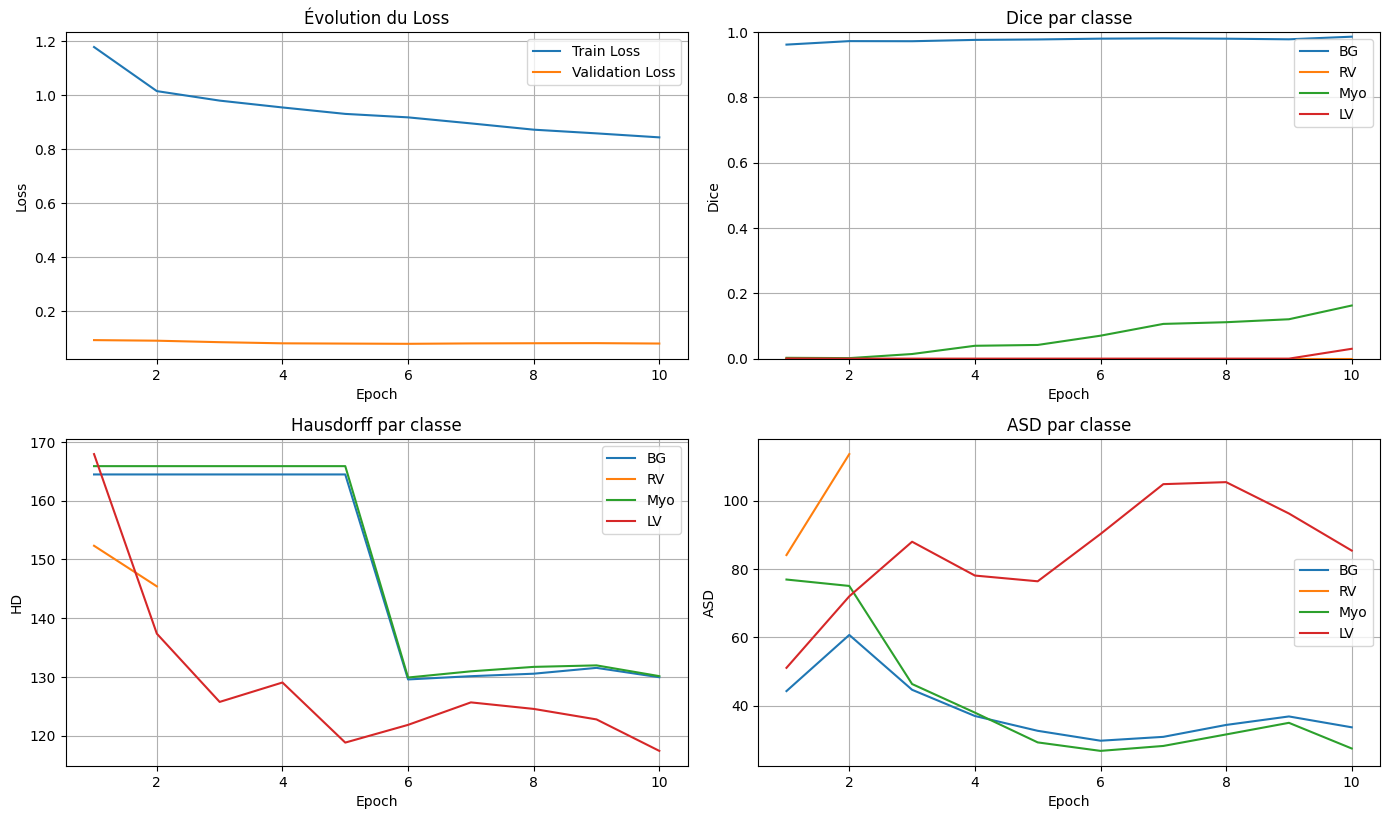

In [87]:
def plot_metrics_curves(loss_train, loss_val, dice_list, hd_list, asd_list, class_names=None):
    """
    Affiche les courbes de métriques pour segmentation multi-classes.

    loss_train, loss_val : listes des pertes
    dice_list, hd_list, asd_list : listes d'array par epoch (shape = (num_classes,))
    class_names : liste de noms pour les classes (optionnel)
    """

    # ========= Harmonisation des longueurs =========
    min_len = min(
        len(loss_train),
        len(loss_val),
        len(dice_list),
        len(hd_list),
        len(asd_list)
    )

    loss_train = loss_train[:min_len]
    loss_val   = loss_val[:min_len]
    dice_list  = dice_list[:min_len]
    hd_list    = hd_list[:min_len]
    asd_list   = asd_list[:min_len]

    epochs = np.arange(1, min_len + 1)

    # Convert to numpy arrays
    dice_array = np.array(dice_list)
    hd_array   = np.array(hd_list)
    asd_array  = np.array(asd_list)

    # ======= Fix shape if needed =======
    def ensure_2d(arr):
        arr = np.array(arr)
        if arr.ndim == 1:     # shape = (epochs,)
            arr = arr.reshape(-1, 1)
        return arr

    dice_array = ensure_2d(dice_array)
    hd_array   = ensure_2d(hd_array)
    asd_array  = ensure_2d(asd_array)

    num_classes = dice_array.shape[1]

    if class_names is None:
        class_names = [f"Classe {i}" for i in range(num_classes)]

    num_metrics = 3  # dice, hd, asd
    num_cols = 2
    num_rows = 1 + num_metrics

    plt.figure(figsize=(14, 4 * num_rows))

    # ====================
    # 1. TRAIN / VAL LOSS
    # ====================
    plt.subplot(num_rows, num_cols, 1)
    plt.plot(epochs, loss_train, label="Train Loss")
    plt.plot(epochs, loss_val, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Évolution du Loss")
    plt.legend()
    plt.grid(True)

    # ====================
    # 2. DICE
    # ====================
    plt.subplot(num_rows, num_cols, 2)
    for c in range(num_classes):
        plt.plot(epochs, dice_array[:, c], label=class_names[c])
    plt.xlabel("Epoch")
    plt.ylabel("Dice")
    plt.ylim(0, 1)
    plt.title("Dice par classe")
    plt.grid(True)
    plt.legend()

    # ====================
    # 3. HAUSDORFF
    # ====================
    plt.subplot(num_rows, num_cols, 3)
    for c in range(num_classes):
        plt.plot(epochs, hd_array[:, c], label=class_names[c])
    plt.xlabel("Epoch")
    plt.ylabel("HD")
    plt.title("Hausdorff par classe")
    plt.grid(True)
    plt.legend()

    # ====================
    # 4. ASD
    # ====================
    plt.subplot(num_rows, num_cols, 4)
    for c in range(num_classes):
        plt.plot(epochs, asd_array[:, c], label=class_names[c])
    plt.xlabel("Epoch")
    plt.ylabel("ASD")
    plt.title("ASD par classe")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()



# plot_metrics_curves(lossTotalTraining, val_loss_list, dice_list, hd_list, asd_list)

class_names = ["BG", "RV", "Myo", "LV"]

plot_metrics_curves(
    loss_train=lossTotalTraining_b,
    loss_val=val_loss_list_b,
    dice_list=dice_list_b,
    hd_list=hd_list_b,
    asd_list=asd_list_b,
    class_names=class_names
)


À chaque epoch, le modèle passe successivement par :

- une phase d'entraînement (LossG),
- une phase de validation (val_loss),
- une vérification si le modèle est le meilleur jusqu’ici.

Dans cette fonction, nous avons ajouté :
<p style="color:lightgreen">
- Une fonction pour évaluer le modèle à chaque epoch<br>
- Une fonction pour calculer le Dice score
</p>

La classe 0 correspond au background, la classe 1 au ventricule droit, la classe 2 à la myocarde, la classe 3 au ventricule gauche.
Score de base du modèle UNet : 
classe 1 -> 65-70%
classe 2 -> 75-80%
classe 3 -> 75-80%

## 5.0 - Les fonction MAC

In [ ]:
def stop_notebook():
    raise KeyboardInterrupt("Arrêt volontaire du run")
stop_notebook()

KeyboardInterrupt: Arrêt volontaire du run

In [ ]:
# ==========================================
# 1. VALIDATION (Inchangé)
# ==========================================
def validate_Mac(model, loader, criterion, num_classes, device, visualise=True, n_examples=1, show_confusion=True):
    model.eval()
    total_loss = 0.0
    dice_accumulator = [] 
    all_preds = []
    all_gts = []
    example_count = 0
    cmap = "jet"
    class_colors = plt.cm.get_cmap(cmap, num_classes)
    legend_patches = [mpatches.Patch(color=class_colors(i), label=f"Classe {i}") for i in range(num_classes)]
    
    with torch.no_grad():
        for images, labels, _ in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            segmentation_classes = getTargetSegmentation(labels).to(device)
            loss = criterion(outputs, segmentation_classes)
            total_loss += loss.item()

            images_cpu = images.detach().cpu()
            outputs_cpu = outputs.detach().cpu()
            seg_classes_cpu = segmentation_classes.detach().cpu()
            
            d_score = dice_score(outputs_cpu, seg_classes_cpu, num_classes)
            dice_accumulator.append(d_score.numpy())

            if show_confusion:
                preds_argmax = torch.argmax(outputs_cpu, dim=1)
                all_preds.append(preds_argmax.view(-1).numpy())
                all_gts.append(seg_classes_cpu.view(-1).numpy())

            if visualise and example_count < n_examples:
                batch_size = images.shape[0]
                to_show = min(batch_size, n_examples - example_count)
                for idx in range(to_show):
                    example_count += 1
                    img_np = images_cpu[idx][0].numpy()
                    gt_np = seg_classes_cpu[idx].numpy()
                    pred_np = torch.argmax(outputs_cpu[idx], dim=0).numpy()

                    plt.figure(figsize=(16, 4))
                    plt.subplot(1, 4, 1); plt.imshow(img_np, cmap="gray"); plt.title("Originale"); plt.axis("off")
                    plt.subplot(1, 4, 2); plt.imshow(gt_np, cmap=cmap, vmin=0, vmax=num_classes-1); plt.title("Ground Truth"); plt.axis("off")
                    plt.subplot(1, 4, 3); plt.imshow(pred_np, cmap=cmap, vmin=0, vmax=num_classes-1); plt.title("Prédiction"); plt.axis("off")
                    plt.subplot(1, 4, 4); plt.imshow(img_np, cmap="gray"); plt.imshow(pred_np, cmap=cmap, alpha=0.5, vmin=0, vmax=num_classes-1); plt.title("Overlay"); plt.axis("off")
                    plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5))
                    plt.tight_layout(); plt.show()

    if show_confusion and len(all_preds) > 0:
        print("\nGénération de la matrice de confusion...")
        preds_flat = np.concatenate(all_preds)
        gts_flat = np.concatenate(all_gts)
        cm = confusion_matrix(gts_flat, preds_flat, labels=np.arange(num_classes))
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[f"Pred {i}" for i in range(num_classes)], yticklabels=[f"Vrai {i}" for i in range(num_classes)])
        plt.title("Matrice de Confusion"); plt.ylabel("Réelle"); plt.xlabel("Prédite"); plt.show()

    return total_loss / len(loader), np.mean(dice_accumulator, axis=0)

# ==========================================
# 2. ENTRAÎNEMENT (Avec nom de dossier personnalisé)
# ==========================================
def runTraining_Mac_ARM(model_class, batch_size=4, lr=0.001, epoch=10, experiment_name="Exp_Default"):
    """
    experiment_name : Nom du sous-dossier dans ./models/ où seront sauvegardés les fichiers .pth
    """
    print('=' * 60); print(f'🍎  Training: {experiment_name} (Mac M4) 🍎'); print('=' * 60)
    global_start_time = time.time()
    
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
    
    # --- GESTION DES DOSSIERS DE SAUVEGARDE ---
    # Répertoire courant -> models -> experiment_name
    save_dir = os.path.join(os.getcwd(), 'models', experiment_name)
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"📁 Dossier créé : {save_dir}")
    else:
        print(f"📁 Dossier existant : {save_dir}")

    # Chargement Données
    root_dir = './Data/'
    transform = transforms.Compose([transforms.ToTensor()])
    mask_transform = transforms.Compose([transforms.ToTensor()])

    train_set = medicalDataLoader.MedicalImageDataset('train', root_dir, transform=transform, mask_transform=mask_transform, augment=True, equalize=False)
    train_loader = DataLoader(train_set, batch_size=batch_size, worker_init_fn=np.random.seed(0), num_workers=0, shuffle=True)
    val_set = medicalDataLoader.MedicalImageDataset('val', root_dir, transform=transform, mask_transform=mask_transform, equalize=False)
    val_loader = DataLoader(val_set, batch_size=batch_size, worker_init_fn=np.random.seed(0), num_workers=0, shuffle=False)
    
    num_classes = 4 
    net = model_class(num_classes).to(device)
    
    class_weights = torch.tensor([0.1, 5, 5, 5], dtype=torch.float).to(device)
    CE_loss = torch.nn.CrossEntropyLoss(weight=class_weights).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    lossTotalTraining = []
    val_loss_list = []
    dice_history = []
    
    Best_loss_val = 1000
    BestEpoch = 0
    best_model_path = "" 

    print("\n🚀 Début de l'entraînement...")

    for i in range(epoch):
        net.train() 
        lossEpoch = []
        num_batches = len(train_loader)
        
        for j, data in enumerate(train_loader):
            optimizer.zero_grad()
            images, labels, _ = data
            images = images.to(device); labels = labels.to(device)
            
            net_predictions = net(images)
            segmentation_classes = getTargetSegmentation(labels).to(device)
            
            loss = CE_loss(net_predictions, segmentation_classes)
            loss.backward()
            optimizer.step()
            lossEpoch.append(loss.item())
            printProgressBar(j + 1, num_batches, prefix=f"[Epoch {i}/{epoch-1}]", length=15, suffix=f"Loss: {loss.item():.4f}")

        mean_loss_epoch = np.mean(lossEpoch)
        lossTotalTraining.append(mean_loss_epoch)
        
        # Validation
        is_last_epoch = (i == epoch - 1)
        print(f"\n--- Validation Epoch {i} ---")
        val_loss, val_dices_array = validate_Mac(net, val_loader, CE_loss, num_classes, device, visualise=True, n_examples=1, show_confusion=is_last_epoch)
        
        val_loss_list.append(val_loss)
        dice_history.append(val_dices_array)
        
        print(f"   📉 Train Loss: {mean_loss_epoch:.4f} | Val Loss: {val_loss:.4f}")
        print(f"   📊 Dice: {val_dices_array}")

        # Sauvegarde
        if val_loss < Best_loss_val:
            Best_loss_val = val_loss
            BestEpoch = i
            # Sauvegarde dans le dossier personnalisé
            best_model_path = os.path.join(save_dir, f"Best_Model_Epoch_{i}.pth")
            torch.save(net.state_dict(), best_model_path)
            print(f"      🏆 Record sauvegardé dans : {experiment_name}/Best_Model_Epoch_{i}.pth")
        
        print("-" * 60)

    total_time = time.time() - global_start_time
    print(f"\n🏁 Terminé en {int(total_time // 60)}m {int(total_time % 60)}s")
    
    # Rechargement du meilleur modèle
    if best_model_path and os.path.exists(best_model_path):
        print(f"🔄 Chargement des poids de la meilleure époque ({BestEpoch})...")
        net.load_state_dict(torch.load(best_model_path))
    
    return net, lossTotalTraining, val_loss_list, dice_history

La classe 0 correspond au background, la classe 1 au ventricule droit, la classe 2 à la myocarde, la classe 3 au ventricule gauche.
Score de base du modèle UNet : 
classe 1 -> 65-70%
classe 2 -> 75-80%
classe 3 -> 75-80%

In [ ]:
# Exemple 1 : Test de base
net, loss, val_loss, dice = runTraining_Mac_ARM(UNet_2, 4, 0.001, 20, experiment_name="UNet2_Base")

# Exemple 2 : Test avec learning rate faible
# net, loss, val_loss, dice = runTraining_Mac_ARM(UNet_2, 4, 0.0001, 20, experiment_name="UNet2_LR_Low")

In [ ]:
def continueTraining_Mac_ARM(model_class, checkpoint_path, batch_size=4, lr=0.001, epochs_to_add=10, new_experiment_name="Exp_Continued"):
    """
    Reprend l'entraînement à partir d'un fichier .pth existant.
    
    Args:
        checkpoint_path (str): Chemin complet vers le fichier .pth (ex: './models/Exp1/Best_Model_Epoch_5.pth')
        epochs_to_add (int): Nombre d'époques SUPPLÉMENTAIRES à effectuer.
        new_experiment_name (str): Nom du dossier pour les nouvelles sauvegardes.
    """
    print('=' * 60); print(f'♻️  Reprise Entraînement : {new_experiment_name} ♻️'); print('=' * 60)
    global_start_time = time.time()
    
    # 1. Device
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
    print(f"✅ Device: {device}")

    # 2. Gestion Dossiers
    save_dir = os.path.join(os.getcwd(), 'models', new_experiment_name)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # 3. Data Loaders (Identique)
    root_dir = './Data/'
    transform = transforms.Compose([transforms.ToTensor()])
    mask_transform = transforms.Compose([transforms.ToTensor()])

    train_set = medicalDataLoader.MedicalImageDataset('train', root_dir, transform=transform, mask_transform=mask_transform, augment=True, equalize=False)
    train_loader = DataLoader(train_set, batch_size=batch_size, worker_init_fn=np.random.seed(0), num_workers=0, shuffle=True)
    val_set = medicalDataLoader.MedicalImageDataset('val', root_dir, transform=transform, mask_transform=mask_transform, equalize=False)
    val_loader = DataLoader(val_set, batch_size=batch_size, worker_init_fn=np.random.seed(0), num_workers=0, shuffle=False)
    
    # 4. INIT MODÈLE & CHARGEMENT DES POIDS
    num_classes = 4 
    net = model_class(num_classes).to(device)
    
    print(f"📂 Chargement des poids depuis : {checkpoint_path}")
    if os.path.isfile(checkpoint_path):
        # map_location est crucial pour éviter les erreurs de device entre sauvegardes
        net.load_state_dict(torch.load(checkpoint_path, map_location=device))
        print("✅ Poids chargés avec succès !")
    else:
        print(f"❌ ERREUR : Le fichier {checkpoint_path} n'existe pas.")
        return None

    # 5. Loss & Optimizer
    # Note : On repart avec un optimiseur "neuf" (LR reset à la valeur fournie)
    class_weights = torch.tensor([0.1, 5, 5, 5], dtype=torch.float).to(device)
    CE_loss = torch.nn.CrossEntropyLoss(weight=class_weights).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    lossTotalTraining = []
    val_loss_list = []
    dice_history = []
    
    # On initialise le "Best Loss" assez haut pour qu'il sauvegarde si le modèle s'améliore
    # Ou idéalement, on devrait valider une fois avant de commencer pour avoir la baseline.
    Best_loss_val = 1000 
    BestEpoch = 0
    best_model_saved_path = ""

    print(f"\n🚀 Reprise pour {epochs_to_add} époques supplémentaires...")

    for i in range(epochs_to_add):
        net.train() 
        lossEpoch = []
        num_batches = len(train_loader)
        
        for j, data in enumerate(train_loader):
            optimizer.zero_grad()
            images, labels, _ = data
            images = images.to(device); labels = labels.to(device)
            
            net_predictions = net(images)
            segmentation_classes = getTargetSegmentation(labels).to(device)
            
            loss = CE_loss(net_predictions, segmentation_classes)
            loss.backward()
            optimizer.step()
            lossEpoch.append(loss.item())
            printProgressBar(j + 1, num_batches, prefix=f"[Epoch {i+1}/{epochs_to_add}]", length=15, suffix=f"Loss: {loss.item():.4f}")

        mean_loss_epoch = np.mean(lossEpoch)
        lossTotalTraining.append(mean_loss_epoch)
        
        # Validation
        is_last_epoch = (i == epochs_to_add - 1)
        print(f"\n--- Validation Epoch {i+1} ---")
        val_loss, val_dices_array = validate_Mac(net, val_loader, CE_loss, num_classes, device, visualise=True, n_examples=1, show_confusion=is_last_epoch)
        
        val_loss_list.append(val_loss)
        dice_history.append(val_dices_array)
        
        print(f"   📉 Train Loss: {mean_loss_epoch:.4f} | Val Loss: {val_loss:.4f}")
        print(f"   📊 Dice: {val_dices_array}")

        # Sauvegarde
        if val_loss < Best_loss_val:
            Best_loss_val = val_loss
            BestEpoch = i + 1
            best_model_saved_path = os.path.join(save_dir, f"Continued_Best_Epoch_{i+1}.pth")
            torch.save(net.state_dict(), best_model_saved_path)
            print(f"      🏆 Nouveau Record (Session courante) : {best_model_saved_path}")
        
        print("-" * 60)

    total_time = time.time() - global_start_time
    print(f"\n🏁 Session terminée en {int(total_time // 60)}m {int(total_time % 60)}s")
    
    # Recharger le meilleur de CETTE session
    if best_model_saved_path and os.path.exists(best_model_saved_path):
        net.load_state_dict(torch.load(best_model_saved_path))
        
    return net, lossTotalTraining, val_loss_list, dice_history

In [ ]:
# 1. Définir le chemin du modèle à charger
path_to_model = "./models/UNet2_Base/Best_Model_Epoch_18.pth"

# 2. Lancer la reprise
# Je vous conseille de baisser un peu le Learning Rate (lr) lors d'une reprise pour affiner (fine-tuning)
net, loss, val_loss, dice = continueTraining_Mac_ARM(
    UNet_2, 
    checkpoint_path=path_to_model, 
    batch_size=8, 
    lr=0.0005,   # On baisse un peu le LR pour ne pas "casser" les poids existants trop vite
    epochs_to_add=50, 
    new_experiment_name="UNet2_Base_Continued"
)

In [ ]:

def plot_training_curves(loss_train, loss_val, dice_list):

    epochs = np.arange(1, len(loss_train) + 1)

    plt.figure(figsize=(14,5))

    # ----- TRAIN / VAL LOSS -----
    plt.subplot(1,2,1)
    plt.plot(epochs, loss_train, label="Train Loss")
    plt.plot(epochs, loss_val, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Évolution du Loss")
    plt.legend()
    plt.grid(True)

    # ----- DICE SCORE -----
    plt.subplot(1,2,2)
    
    dice_array = np.array(dice_list)  # shape: [epochs, num_classes]
    num_classes = dice_array.shape[1]

    for c in range(num_classes):
        plt.plot(epochs, dice_array[:, c], label=f"Classe {c}")

    plt.xlabel("Epoch")
    plt.ylabel("Dice")
    plt.title("Évolution du Dice par classe")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_curves(lossTotalTraining, val_loss_list, dice_list)

On observe que la perte d’entraînement reste stable autour de 1.07 pour toutes les époques :
- Cela indique que le modèle baseline apprend très peu, ou pas du tout.
- Le modèle apprend un peu au début (jusqu'à epoch : 6), puis commence à stagner ou légèrement sur-apprendre
- Meilleur modèle = epoch 6

A faire ensuite :
- Améliore le modèle
- faire un dice score
- visualiser les différentes étapes/prédictions

**Selon l'ami le chat :**

🔍 Que vérifier maintenant ?

Parce que ton loss stable est louche, tu devrais vérifier :

✔ 1. getTargetSegmentation(labels)

Est-ce que ça renvoie bien un tenseur [B,H,W] d'entiers (classes) ?

✔ 2. Les labels contiennent plusieurs classes ?

Si tout est 0 → CE ~1.07 est normal.

✔ 3. Le learning rate

lr = 0.01 est assez agressif pour UNet.
Essaie 0.001 ou 0.0001.

✔ 4. Visualiser quelques prédictions

Pour vérifier que les masques prévus ne sont pas tous pareils.